<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling/blob/main/Object_Detection_in_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Connection and Packages Importation**

In [15]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sn

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
import torchvision.models as models 

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'cuda'

# **Object Detection, 객체 탐지**  


---





## **PennFudan Dataset Preparation and PreProcessing**  
보행자 Detection과 Segmentation을 위한 Dataset. 170개의 Image와 345명의 labeled된 보행자 데이터 존재. University of Pennsylvania와 Fudan University에서 수집한 데이터셋

/content/drive/MyDrive/Colab Notebooks/AI Algorithm Modeling/data



1


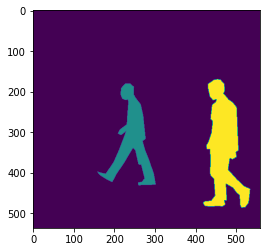

In [20]:
# Setting Directory path
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data")
print(root)
print()


# Get Sample Image of PennFudan and Plot
sample_img = Image.open(os.path.join(root, "PennFudanPed/PNGImages/FudanPed00001.png"))
plt.imshow(sample_img)
print()

sample_mask = Image.open(os.path.join(root, "PennFudanPed/PedMasks/FudanPed00001_mask.png"))
plt.imshow(sample_mask)
print()

print(np.array(sample_mask)[300, 250])

In [21]:
## Definition of PennFudan Datset for Object Detection and Semantic Segmentation

class ODDataset(Dataset):
    def __init__(self, root, transforms=None, mode="detection"):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

        self.mode = mode
        if not (self.mode == "detection" or self.mode == "segmentation"):
            raise ValueError(f"Inputted Mode {self.mode} is not supported.")
    
    def __getitem__(self, idx):                                                 # Image and Mask Importation
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        if self.mode == "detection":                                            # mode = Object Detection인 경우
            obj_ids = np.unique(mask)
            obj_ids = obj_ids[1:]                                               # 0 값은 Background이므로 제거
            masks = mask == obj_ids[:, None, None]                              # 각 object id 별로 mask를 따로 만들어줌 & slicing 속성으로 None 입력하면 해당 axis를 기준으로 차원 증가
            num_objs = len(obj_ids)

            boxes = []                                                          # object 별 mask 의 가장자리 위치를 기준으로 Bounding Box 를 만듦
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.min(pos[1])
                ymin = np.min(pos[0])
                ymax = np.min(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((num_objs), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels

            if self.transforms is not None:
                img, target = self.transforms(img, target)
            
            return img, target
        
        elif self.mode == "segmentation":                                       # mode = Semantic Segmentation인 경우
            mask[mask > 0] = 1                                                  # object 가 있는 부분은 전부 1로 mask value 수정 -> 다 같은 Pedestrian class label
            mask = torch.as_tensor(mask, dtype=torch.float32)

            target = {}
            target["mask"] = mask
            
            if self.transforms is not None:
                img, target = self.transforms(img, target)
            
            return img, target
    
    def __len__(self):
        return len(self.imgs)


## Definition of Transforms for Data Pre-Processing

class ToTensor(object):
    def __call__(self, img, target):
        img = transforms.ToTensor()(img)
        return img, target

class Normalize(object):
    def __call__(self, img, target):
        img = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
        return img, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img, target):
        for tf in self.transforms:
            img, target = tf(img, target)
        return img, target

apply_transform = Compose([ToTensor()])
od_dataset = ODDataset(os.path.join(root, "PennFudanPed"), transforms=apply_transform, mode="detection")
od_dataset[0]

(tensor([[[0.8275, 0.8235, 0.8314,  ..., 0.5608, 0.5725, 0.5804],
          [0.7020, 0.6784, 0.6667,  ..., 0.4941, 0.5020, 0.5020],
          [0.8000, 0.7608, 0.7373,  ..., 0.5098, 0.5137, 0.5098],
          ...,
          [0.8863, 0.8510, 0.8275,  ..., 0.7176, 0.7216, 0.7255],
          [0.9059, 0.8588, 0.8235,  ..., 0.7333, 0.7333, 0.7294],
          [0.8824, 0.8902, 0.8431,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7843, 0.7804, 0.7882,  ..., 0.3765, 0.3882, 0.3961],
          [0.6588, 0.6353, 0.6235,  ..., 0.3098, 0.3176, 0.3176],
          [0.7569, 0.7176, 0.6941,  ..., 0.3255, 0.3294, 0.3255],
          ...,
          [0.8627, 0.8275, 0.8039,  ..., 0.7176, 0.7216, 0.7255],
          [0.8824, 0.8353, 0.8000,  ..., 0.7333, 0.7333, 0.7294],
          [0.8588, 0.8667, 0.8196,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7137, 0.7098, 0.7176,  ..., 0.3059, 0.3176, 0.3255],
          [0.5882, 0.5647, 0.5529,  ..., 0.2392, 0.2471, 0.2471],
          [0.6863, 0.6471, 0.6235,  ...,

## **대표적인 Pretrained Object Detection Model**

### **① Faster R-CNN --- PASCAL VOC 2012 mAP = 70.4%**  
- 기존의 R-CNN 계열에서 사용하던 **Selective Search의 단점을 보완**한 Network
- Image 전체를 CNN에 Input으로 삽입하여 feature map 추출 + **Region Proposal Network(RPN) 사용**
- 미리 지정한 **K개의 anchor box들**에 대해, 각 anchor box마다 물체의 존재 여부 **Classification(2K)** 및 **B-Boxes Regression(4K)** Task 수행
- **각 RoI feature 마다 Fully-Connected Layer**를 사용하여 Classification 수행
- **빠른 수행 속도(5fps) 및 End-to-End Model**  

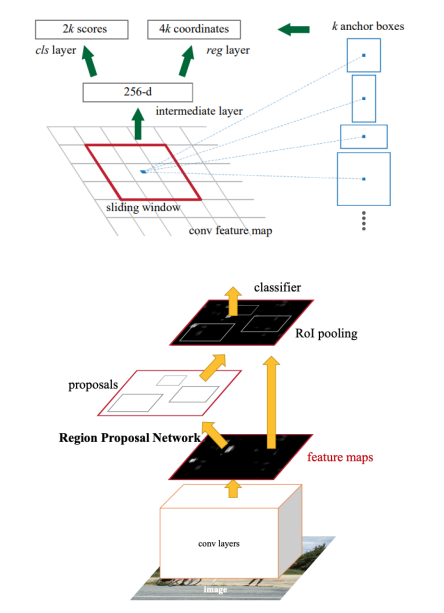

In [22]:
## ① Faster R-CNN Importation and Prediction
faster_rcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

faster_rcnn_loader = DataLoader(od_dataset, batch_size=1, shuffle=True)
fr_imgs, fr_targets = next(iter(faster_rcnn_loader))

faster_rcnn.eval()
fr_predictions = faster_rcnn(fr_imgs)

print(fr_targets)
print(fr_predictions)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'boxes': tensor([[[ 79.,  85.,  79.,  85.],
         [278.,  93., 278.,  93.],
         [410., 100., 410., 100.]]]), 'labels': tensor([[1, 1, 1]])}
[{'boxes': tensor([[ 72.1718,  84.0424, 205.6764, 379.3767],
        [281.2227,  94.8320, 397.3039, 360.9965],
        [406.6700,  96.0766, 490.0135, 374.8799],
        [240.5973, 100.0222, 303.1819, 252.8948],
        [223.8517,  99.0512, 265.1213, 181.2748],
        [386.3464, 103.1836, 424.9300, 256.7857],
        [359.1746, 106.5430, 406.0433, 249.3170],
        [371.0251, 183.2937, 405.7403, 279.3405],
        [469.2741, 114.1992, 497.3761, 265.0117],
        [259.4786, 176.0267, 296.5861, 273.4386],
        [230.0417, 173.7781, 252.7923, 222.5801],
        [248.1053, 134.3629, 287.6382, 203.4009],
        [458.0220, 110.8850, 494.7587, 323.1224],
        [248.9462, 169.5825, 281.0010, 199.2499],
        [275.5922, 129.2499, 293.4666, 200.2597],
        [477.4797, 125.7546, 498.2625, 227.9087],
        [238.0132, 151.1323, 299.9252, 2

### **② SSD(Single Shot Multi-Box Detector) --- PASCAL VOC 2012 mAP = 80.0%**  
- Input단과 가까운 Conv layer의 feature들을 직접 Detection에 사용하여 detail을 살림
- Anchor box를 활용해 다양한 형태의 Object를 Detection  
  
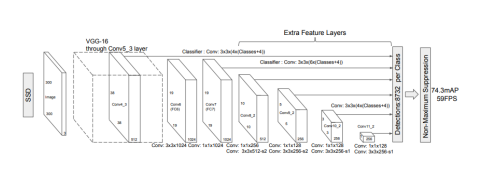

In [23]:
## ② SSD Importation and Prediction
ssd = models.detection.ssd300_vgg16(pretrained=True)

ssd_loader = DataLoader(od_dataset, batch_size=1, shuffle=True)
ssd_imgs, ssd_targets = next(iter(ssd_loader))

ssd.eval()
ssd_predictions = ssd(ssd_imgs)

print(ssd_targets)
print(ssd_predictions)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'boxes': tensor([[[352.,  98., 352.,  98.]]]), 'labels': tensor([[1]])}
[{'boxes': tensor([[3.5016e+02, 9.6582e+01, 4.6627e+02, 3.8004e+02],
        [1.9205e+02, 2.8347e+02, 4.0642e+02, 4.1532e+02],
        [2.2527e+00, 2.2118e+02, 9.7758e+01, 3.8380e+02],
        [8.7712e+00, 2.1858e+02, 2.0592e+02, 3.8709e+02],
        [2.1797e+02, 2.7795e+02, 3.7269e+02, 3.4988e+02],
        [2.6892e+02, 2.9501e+02, 3.2263e+02, 3.4134e+02],
        [3.5363e+02, 2.1279e+02, 4.0032e+02, 3.2002e+02],
        [3.0067e+02, 3.0328e+02, 3.6382e+02, 3.4008e+02],
        [3.7188e+02, 2.1568e+02, 4.4114e+02, 3.0912e+02],
        [2.4679e-01, 2.0372e+02, 1.0182e+02, 2.9001e+02],
        [2.3267e+02, 2.9738e+02, 2.9528e+02, 3.4031e+02],
        [3.6158e+02, 9.8281e+01, 3.9188e+02, 1.4037e+02],
        [2.2786e+02, 2.6331e+02, 2.8619e+02, 3.4794e+02],
        [1.0969e+01, 2.8928e+02, 8.5240e+01, 3.8297e+02],
        [7.1379e+01, 2.4248e+02, 3.4782e+02, 4.1821e+02],
        [2.2659e+02, 2.8501e+02, 2.8990e+02, 4

## **Get Object Classes by COCO Labels**

In [25]:
## COCO Labels Importation

COCO_labels = np.array(open(os.path.join(root, "COCO_labels.txt")).read().splitlines())
print(COCO_labels)
print()

COCO_faster_rcnn = COCO_labels[fr_predictions[0]["labels"]]
print(f"Faster R-CNN Predictions = {COCO_faster_rcnn}")
print()
COCO_ssd = COCO_labels[ssd_predictions[0]["labels"]]
print(f"SSD Predictions = {COCO_ssd}")

['background' 'person' 'bicycle' 'car' 'motorcycle' 'airplane' 'bus'
 'train' 'truck' 'boat' 'traffic light' 'fire hydrant' 'street sign'
 'stop sign' 'parking meter' 'bench' 'bird' 'cat' 'dog' 'horse' 'sheep'
 'cow' 'elephant' 'bear' 'zebra' 'giraffe' 'hat' 'backpack' 'umbrella'
 'shoe' 'eye glasses' 'handbag' 'tie' 'suitcase' 'frisbee' 'skis'
 'snowboard' 'sports ball' 'kite' 'baseball bat' 'baseball glove'
 'skateboard' 'surfboard' 'tennis racket' 'bottle' 'plate' 'wine glass'
 'cup' 'fork' 'knife' 'spoon' 'bowl' 'banana' 'apple' 'sandwich' 'orange'
 'broccoli' 'carrot' 'hot dog' 'pizza' 'donut' 'cake' 'chair' 'couch'
 'potted plant' 'bed' 'mirror' 'dining table' 'window' 'desk' 'toilet'
 'door' 'tv' 'laptop' 'mouse' 'remote' 'keyboard' 'cell phone' 'microwave'
 'oven' 'toaster' 'sink' 'refrigerator' 'blender' 'book' 'clock' 'vase'
 'scissors' 'teddy bear' 'hair drier' 'toothbrush' 'hair brush']

Faster R-CNN Predictions = ['person' 'person' 'person' 'person' 'person' 'person' 'pers

## **Get Object Classes by COCO Labels**

In [26]:
## Visualization by PIL ImageDraw

def draw_boxes(img, boxes, labels, pred=False, confs=None, conf_th=None):
    if pred:
        valid = np.where(confs > conf_th)
        boxes = boxes[valid]
        labels = labels[valid]
    
    img_to_draw = Image.fromarray(img)
    draw = ImageDraw.Draw(img_to_draw)

    for i, box in enumerate(boxes):
        draw.rectangle(box)
        draw.text((box[0]+2, box[1]+2), str(labels[i]))
    
    return img_to_draw

Faster R-CNN Prediction Result


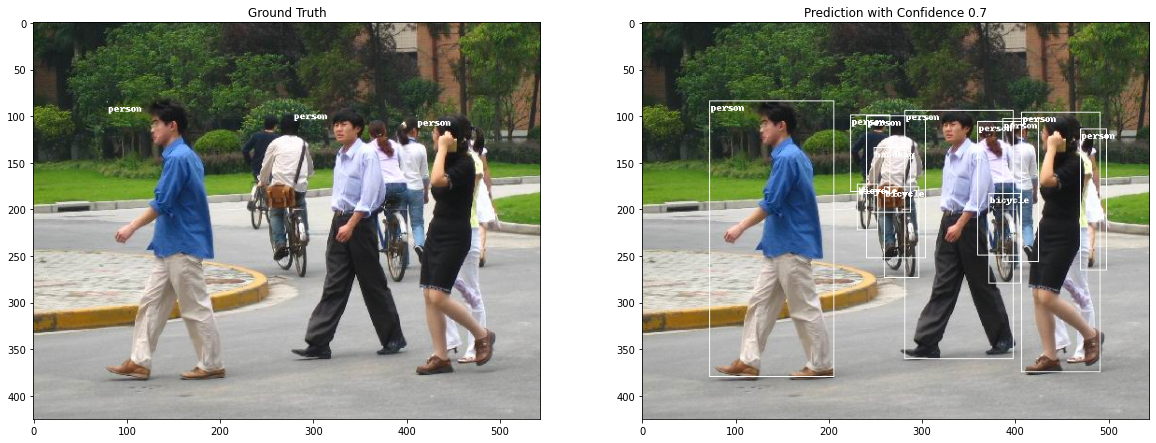

In [27]:
## Visualization for Faster R-CNN Predictions

fr_img = (fr_imgs[0].permute(1, 2, 0).numpy()*255).astype(np.uint8)
fr_gt_boxes = fr_targets["boxes"].detach().numpy()[0]
fr_gt_labels = COCO_labels[fr_targets["labels"]][0]
fr_gt_box_img = draw_boxes(fr_img, fr_gt_boxes, fr_gt_labels)

fr_prediction = fr_predictions[0]
fr_boxes = fr_prediction["boxes"].detach().numpy()
fr_labels = COCO_labels[fr_predictions[0]["labels"]]
fr_conf = fr_prediction["scores"].detach().numpy()

fr_conf_th = 0.7
fr_box_img = draw_boxes(fr_img, fr_boxes, fr_labels, pred=True, confs=fr_conf, conf_th=fr_conf_th)

print("Faster R-CNN Prediction Result")
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(fr_gt_box_img)
ax.title.set_text("Ground Truth")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(fr_box_img)
ax.title.set_text(f"Prediction with Confidence {fr_conf_th}")
fig.show()

SSD Prediction Result


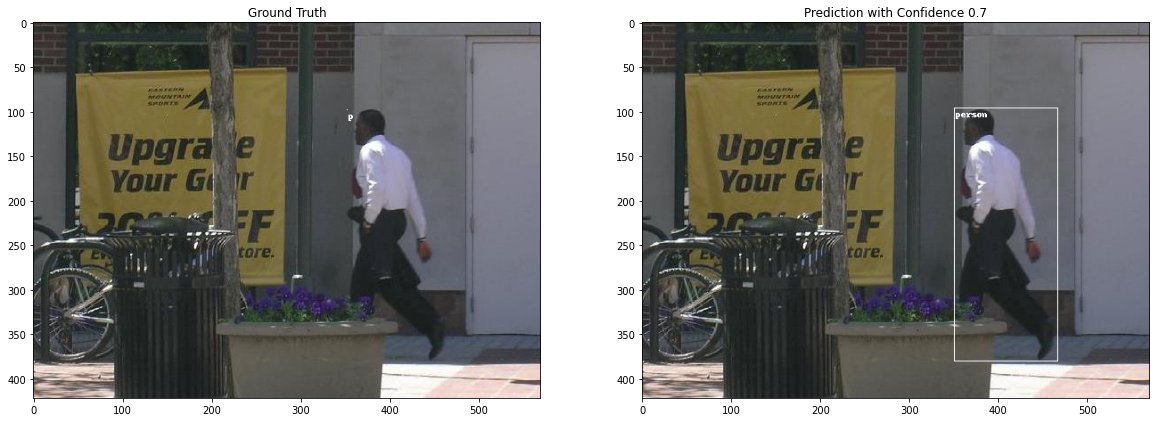

In [28]:
## Visualization for SSD Predictions

ssd_img = (ssd_imgs[0].permute(1, 2, 0).numpy()*255).astype(np.uint8)
ssd_gt_boxes = ssd_targets["boxes"].detach().numpy()[0]
ssd_gt_labels = COCO_labels[ssd_targets["labels"]][0]
ssd_gt_box_img = draw_boxes(ssd_img, ssd_gt_boxes, ssd_gt_labels)

ssd_prediction = ssd_predictions[0]
ssd_boxes = ssd_prediction["boxes"].detach().numpy()
ssd_labels = COCO_labels[ssd_predictions[0]["labels"]]
ssd_conf = ssd_prediction["scores"].detach().numpy()

ssd_conf_th = 0.7
ssd_box_img = draw_boxes(ssd_img, ssd_boxes, ssd_labels, pred=True, confs=ssd_conf, conf_th=ssd_conf_th)

print("SSD Prediction Result")
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ssd_gt_box_img)
ax.title.set_text("Ground Truth")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(ssd_box_img)
ax.title.set_text(f"Prediction with Confidence {ssd_conf_th}")
fig.show()